In [1]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame

In [2]:

df = pd.read_csv('ravenstock.csv', index_col=0)

#df = df.sample(frac=1).reset_index(drop=True)
#df = df.drop(df.columns[[0]], axis=1)
print(df)


                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
1980-03-17   0.145833   0.177083   0.145833   0.145833   0.001069   80000
1980-03-18   0.145833   0.177083   0.145833   0.145833   0.001069    3200
1980-03-19   0.145833   0.145833   0.145833   0.145833   0.001069       0
1980-03-20   0.145833   0.145833   0.145833   0.145833   0.001069       0
1980-03-21   0.145833   0.145833   0.145833   0.145833   0.001069       0
...               ...        ...        ...        ...        ...     ...
2019-08-30  29.280001  29.469999  28.879999  29.170000  29.170000  190900
2019-09-03  28.959999  29.360001  28.430000  29.209999  29.209999  136800
2019-09-04  29.490000  30.280001  29.400000  29.879999  29.879999  120500
2019-09-05  30.350000  31.559999  30.160000  31.379999  31.379999  167300
2019-09-06  31.540001  31.850000  31.030001  31.459999  31.459999  104400

[9955 rows x 6 columns]


In [3]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
print(mavg.to_string())


Date
1980-03-17          NaN
1980-03-18          NaN
1980-03-19          NaN
1980-03-20          NaN
1980-03-21          NaN
1980-03-24          NaN
1980-03-25          NaN
1980-03-26          NaN
1980-03-27          NaN
1980-03-28          NaN
1980-03-31          NaN
1980-04-01          NaN
1980-04-02          NaN
1980-04-03          NaN
1980-04-07          NaN
1980-04-08          NaN
1980-04-09          NaN
1980-04-10          NaN
1980-04-11          NaN
1980-04-14          NaN
1980-04-15          NaN
1980-04-16          NaN
1980-04-17          NaN
1980-04-18          NaN
1980-04-21          NaN
1980-04-22          NaN
1980-04-23          NaN
1980-04-24          NaN
1980-04-25          NaN
1980-04-28          NaN
1980-04-29          NaN
1980-04-30          NaN
1980-05-01          NaN
1980-05-02          NaN
1980-05-05          NaN
1980-05-06          NaN
1980-05-07          NaN
1980-05-08          NaN
1980-05-09          NaN
1980-05-12          NaN
1980-05-13          NaN
1980-05-14 

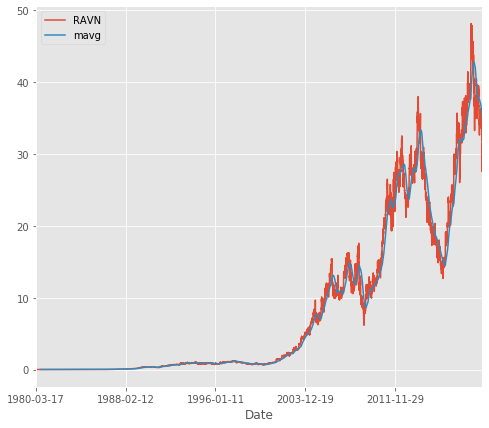

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='RAVN')
mavg.plot(label='mavg')
plt.legend()

In [5]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

In [6]:
import math
import numpy as np
import sklearn

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
len(X)

9855

In [9]:
#Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
confidencereg = clfreg.score(X_test, y_test)

In [10]:
confidencereg

0.9567733032544018

In [11]:
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
confidencepoly2 = clfpoly2.score(X_test,y_test)

In [12]:
confidencepoly2

0.9605840300666821

In [13]:

# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [14]:
confidenceknn = clfknn.score(X_test, y_test)

confidenceknn


0.9348959097683638

In [15]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan

In [16]:

last_date = dfreg.iloc[-1].name
last_unix = last_date

format_str = '%Y-%m-%d' # The format
datetime_obj = datetime.datetime.strptime(last_unix, format_str)
print(datetime_obj.date())


2019-09-06


In [17]:
next_unix = datetime_obj + datetime.timedelta(days=1)

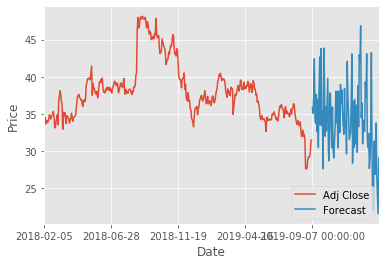

In [18]:


for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(500).plot()
dfreg['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()